<a href="https://colab.research.google.com/github/MECAI2022/short_text_classification/blob/main/LSTM_ShortTextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short Text Classification

## Imports

In [ ]:
from google.colab import drive, output
drive.mount('/content/drive')

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import re
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
!pip install tensorflow_addons
import tensorflow_addons as tfa

!pip install unidecode
import unidecode

import warnings
warnings.filterwarnings('ignore')

output.clear()

## Preparando os Dados

In [ ]:
filepath = "/content/drive/MyDrive/MAI 5003 - Short text classification (Classificação de Produtos)/dataset_produtos.xlsx"
df = pd.read_excel(filepath)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158113 entries, 0 to 158112
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   nm_item       158113 non-null  object
 1   segmento      158113 non-null  object
 2   categoria     158113 non-null  object
 3   subcategoria  158113 non-null  object
 4   nm_product    158113 non-null  object
dtypes: object(5)
memory usage: 6.0+ MB


In [ ]:
# Função para limpar o dataset
def remove_stopwords(sentence):

    # List of stopwords
    stopwords = nltk.corpus.stopwords.words('portuguese')

    # Remove all the special characters
    sentence = re.sub(r'\W', ' ', str(sentence))

    # remove all single characters
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)

    # Remove single characters from the start
    sentence = re.sub(r'\^[a-zA-Z]\s+', ' ', sentence) 
    
    # Substituting multiple spaces with single space
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

    # Removing prefixed 'b'
    sentence = re.sub(r'^b\s+', '', sentence)
    
    # Converting to Lowercase
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    sentence = unidecode.unidecode(sentence)

    return sentence

In [ ]:
# Aplicando de limpeza no dataset
df['corpus'] = df['nm_item'] + ' ' + df['nm_product'] 
df['nm_item'] = df['nm_item'].map(lambda x: remove_stopwords(x))
df['corpus'] = df['corpus'].map(lambda x: remove_stopwords(x))
df.head()

,nm_item,segmento,categoria,subcategoria,nm_product,corpus
0,apresuntado rezende pec kg,1-BENS DE CONSUMO,3-FRIOS E LATICINIOS,6-EMBUTIDOS,APRESUNTADO,apresuntado rezende pec kg apresuntado
1,carne suin espinhaco kg,1-BENS DE CONSUMO,1-ACOUGUE E PEIXARIA,1-ACOUGUE,CARNE SUINA,carne suin espinhaco kg carne suina
2,whisky white 1lhorse trad,1-BENS DE CONSUMO,18-BEBIDAS ALCOOLICAS,56-DESTILADOS,WHISKY,whisky white 1lhorse trad whisky
3,whisky johnn walker 1l unred label,1-BENS DE CONSUMO,18-BEBIDAS ALCOOLICAS,56-DESTILADOS,WHISKY,whisky johnn walker 1l unred label whisky
4,lte cond mocasemi desn tp 395g,1-BENS DE CONSUMO,6-MERCEARIA,22-MERCEARIA LACTEA,LEITE CONDENSADO,lte cond mocasemi desn tp 395g leite condensado


### Definindo algumas variáveis globais

Definindo algumas variáveis ​​globais que serão usadas no notebook.

- `EMBEDDING_DIM`: Dimensão do embedding, será utilizada na camada de embedding do modelo.

- `MAX_SEQUENCE_LENGTH`: Comprimento máximo de todas as sequências.

- `MAX_NB_WORDS`: Número máximo de exemplos a serem usados.

In [ ]:
# Dimensão do Embbeding.
EMBEDDING_DIM = 100

# Número máximo que sequência que a rede neural irá utilizar
MAX_SEQUENCE_LENGTH = 15

# O número máximo de palavras a serem usadas. (mais frequente)
MAX_NB_WORDS = 40000

### Gerando o Vocabulário

Para a maioria das terefas de NLP, o passo inicial na praparação dos dados é extrair um vocabulário de palavras do corpus do dataset. É necessário definir como representar os textos em representações numéricas que podem ser usadas para treinar a rede neural. Essas representações são chamadas de Tokens

In [ ]:
# Inicializando a classe Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

# Gerando indices para cada palavra no corpus
tokenizer.fit_on_texts(df['corpus'].values)

# Pega o dicionário de indices de palavras e imprime a quantidade
word_index = tokenizer.word_index
print(f'Encontrou {len(word_index)} tokens únicos.')

Encontrou 34847 tokens únicos.


O parâmetro `num_words` usado no inicializador especifica o número máximo de palavras menos uma (com base na frequência) para manter ao gerar sequências. 

### Texto para Sequeências e Padding

 Agora pode-se usar o resultado da cédula anterior para converter cada uma das frases de entrada em uma sequência de tokens. Em seguida é usado o padding para preencher as sequências em um comprimento uniforme já que é o que o modelo espera receber.

In [ ]:
# Gerando uma lista de sequência de token
sequences = tokenizer.texts_to_sequences(df['nm_item'].values)

# Preenche as sequências para um comprimento uniforme
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (158113, 15)


### Utilizando Word Embedding Pré Treinados

In [ ]:
class Embeddings():
    """
    Classe para ler o arquivo word embedding e criar a matriz de word embedding
    """

    def __init__(self, path, vector_dimension):
        self.path = path 
        self.vector_dimension = vector_dimension
    
    @staticmethod
    def get_coefs(word, *arr): 
        return word, np.asarray(arr, dtype='float32')

    def get_embedding_index(self):
        embeddings_index = dict(self.get_coefs(*o.split(" ")) for o in open(self.path, errors='ignore'))
        return embeddings_index

    def create_embedding_matrix(self, tokenizer, max_features):
        """
        Método pata criar a matrix de word embadding
        """
        model_embed = self.get_embedding_index()

        embedding_matrix = np.zeros((max_features + 1, self.vector_dimension))
        for word, index in tokenizer.word_index.items():
            if index > max_features:
                break
            else:
                try:
                    embedding_matrix[index] = model_embed[word]
                except:
                    continue
        return embedding_matrix

In [ ]:
# baixando word embadding e extraindo zip
!wget http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s100.zip
!unzip /content/download.php?file=embeddings%2Fglove%2Fglove_s100.zip

In [ ]:
# Criando a matrix de word embadding
embed_path = 'glove_s100.txt'
embed_dim = 100
embedding = Embeddings(embed_path, embed_dim)
EMBEDDINGS_MATRIX = embedding.create_embedding_matrix(tokenizer, len(tokenizer.word_counts))

## Modelo

In [ ]:
# Pegando os Labels do dataset
Y1 = pd.get_dummies(df['segmento']).values
print('Shape of label tensor:', Y1.shape)

Y2 = pd.get_dummies(df['categoria']).values
print('Shape of label tensor:', Y2.shape)

Y3 = pd.get_dummies(df['subcategoria']).values
print('Shape of label tensor:', Y3.shape)

Y4 = pd.get_dummies(df['nm_product']).values
print('Shape of label tensor:', Y4.shape)

Shape of label tensor: (158113, 6)
Shape of label tensor: (158113, 70)
Shape of label tensor: (158113, 153)
Shape of label tensor: (158113, 715)


### Seperando os dados

In [ ]:
# Separando os dados em Teste e Treino
X_train, X_test, Y1_train, Y1_test = train_test_split(X,Y1, test_size = 0.2, random_state = 42)
_, _, Y2_train, Y2_test = train_test_split(X,Y2, test_size = 0.2, random_state = 42)
_, _, Y3_train, Y3_test = train_test_split(X,Y3, test_size = 0.2, random_state = 42)
_, _, Y4_train, Y4_test = train_test_split(X,Y4, test_size = 0.2, random_state = 42)

### Contruindo e Compilando o Modelo

Com os dados pré-processados, agora podemos construir o modelo de classificação. 

- `Embadding`: A entrada será uma camada Embedding. A ideia principal aqui é representar cada palavra no vocabulário com vetores. Esses vetores têm pesos treináveis ​​para que, à medida que a rede neural aprende, as palavras com maior probabilidade de aparecer em uma das categorias convergirão para pesos semelhantes. Por exemplo, palavras que aparecem no corpus que são classificados como Mercearia serão agrupados mais próximos.

- `Bidirectional(LSTM)`: Em resumo, A camada LSTM (Long Short-Term Memory) calcula o estado de um passo de tempo atual e o passa para os próximos passos de tempo onde esse estado também é atualizado. O processo se repete até o passo de tempo final, onde a computação da saída é afetada por todos os estados anteriores. Além disso, ela pode ser configurado para ser bidirecional (Este caso) para se possível obter o relacionamento das palavras posteriores com as anteriores.

- `Conv1D`: Redes neurais convolucionais (CNNs ou ConvNets) são classes de redes neurais que usam a operação de convolução em dados de entrada para detectar padrões nos dados.

- `Dropout`: Dropout é uma técnica comum de regularização. A técnica Dropout envolve a omissão de neurônios que atuam como detectores de features da rede neural durante cada etapa de treinamento. A exclusão de cada neurônio é determinada aleatoriamente.

- `MaxPooling1D`: é uma operação de pooling que calcula o valor máximo para patches de um mapa features e o usa para criar um mapa de features com amostragem reduzida (em pool). 

In [ ]:
# Arquiterura da rede

# Definindo as camadas da rede
input_layer = tf.keras.layers.Input(X.shape[1], name='nm_item')
x = tf.keras.layers.Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[EMBEDDINGS_MATRIX], trainable=True)(input_layer)
x = tf.keras.layers.SpatialDropout1D(0.2)(x)
#x = tf.keras.layers.Conv1D(32, 5, activation='relu')(x)
#x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, dropout=0.2, recurrent_dropout=0.2))(x)
#x = tf.keras.layers.Dense(64, activation='relu')(x)

# Saída da rede
segmento = tf.keras.layers.Dense(Y1.shape[1], activation='softmax', name='segmento')(x)
categoria = tf.keras.layers.Dense(Y2.shape[1], activation='softmax', name='categoria')(x)
subcategoria = tf.keras.layers.Dense(Y3.shape[1], activation='softmax', name='subcategoria')(x)
produto = tf.keras.layers.Dense(Y4.shape[1], activation='softmax', name='produto')(x)

# Definindo a entrada e saídas do modelo 
model = Model(inputs=input_layer, outputs=[segmento, categoria, subcategoria, produto])

# Definiando as métricas f1
f1_segmento = tfa.metrics.F1Score(num_classes=Y1.shape[1], average='macro')
f1_categoria = tfa.metrics.F1Score(num_classes=Y2.shape[1], average='macro')
f1_subcategoria = tfa.metrics.F1Score(num_classes=Y3.shape[1], average='macro')
f1_produto = tfa.metrics.F1Score(num_classes=Y4.shape[1], average='macro')

# Especificando o otimizador e compilador do modelo com as funçõpes de perda
# tf.keras.optimizers.Adam(1e-5)
model.compile(optimizer='adam', 
              loss={'segmento': 'categorical_crossentropy', 
                    'categoria': 'categorical_crossentropy',
                    'subcategoria': 'categorical_crossentropy',
                    'produto': 'categorical_crossentropy'},
              metrics={'segmento': [f1_segmento],
                       'categoria': [f1_categoria],
                       'subcategoria': [f1_subcategoria],
                       'produto': [f1_produto]})

# Resumo do modelo
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nm_item (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 15, 100)      3484800     ['nm_item[0][0]']                
                                                                                                  
 spatial_dropout1d_1 (SpatialDr  (None, 15, 100)     0           ['embedding_2[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 400)         481600      ['spatial_dropout1d_1[0][0]

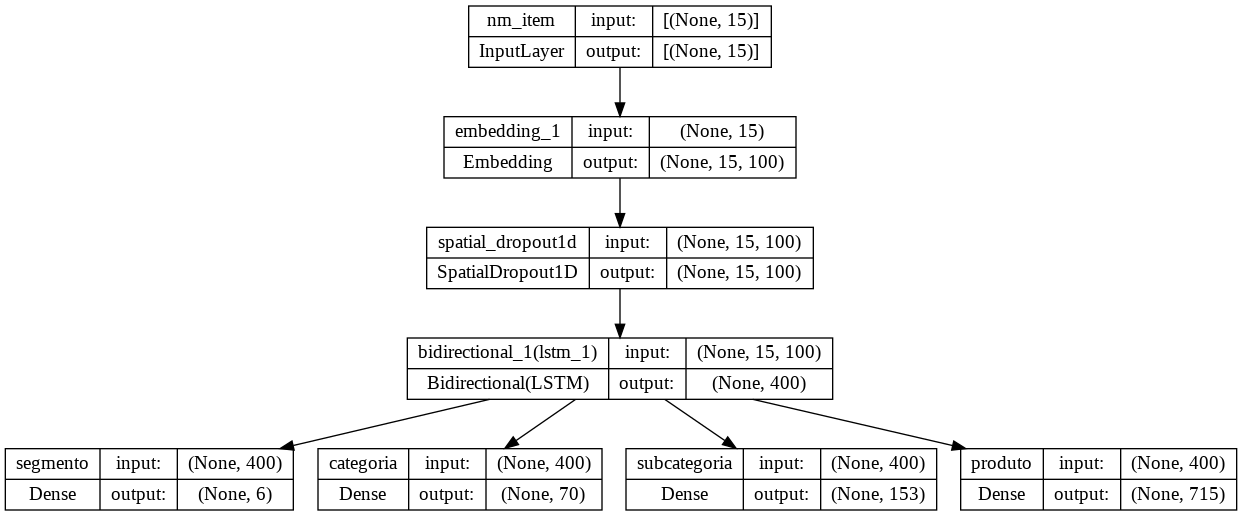

In [ ]:
# Esquema da arquitetura do Modelo
img_file = './model_arch.png'

tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)

### Treinando o Modelo

Próxima etapa é o treinamento do modelo

In [ ]:
epochs = 50
batch_size = 64

#Treinando o Modelo
history = model.fit(X_train, 
                    [Y1_train, Y2_train, Y3_train, Y4_train], 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.2, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
                    )

Epoch 1/50
1582/1582 [==============================] - 322s 164ms/step - loss: 4.1717 - segmento_loss: 0.1140 - categoria_loss: 0.8473 - subcategoria_loss: 1.2053 - produto_loss: 2.0050 - segmento_f1_score: 0.4647 - categoria_f1_score: 0.3161 - subcategoria_f1_score: 0.2780 - produto_f1_score: 0.1830 - val_loss: 1.5883 - val_segmento_loss: 0.0482 - val_categoria_loss: 0.3159 - val_subcategoria_loss: 0.4343 - val_produto_loss: 0.7899 - val_segmento_f1_score: 0.7594 - val_categoria_f1_score: 0.4785 - val_subcategoria_f1_score: 0.4294 - val_produto_f1_score: 0.3419
Epoch 2/50
1582/1582 [==============================] - 249s 157ms/step - loss: 1.5090 - segmento_loss: 0.0441 - categoria_loss: 0.3125 - subcategoria_loss: 0.4215 - produto_loss: 0.7309 - segmento_f1_score: 0.7854 - categoria_f1_score: 0.5096 - subcategoria_f1_score: 0.4742 - produto_f1_score: 0.3977 - val_loss: 1.0456 - val_segmento_loss: 0.0313 - val_categoria_loss: 0.2261 - val_subcategoria_loss: 0.2921 - val_produto_loss:

In [ ]:
# Testando o modelo no conjunto de Teste
accr = model.evaluate(X_test,[Y1_test, Y2_test, Y3_test, Y4_test])

989/989 [==============================] - 13s 13ms/step - loss: 0.7344 - segmento_loss: 0.0250 - categoria_loss: 0.1768 - subcategoria_loss: 0.2125 - produto_loss: 0.3201 - segmento_f1_score: 0.9161 - categoria_f1_score: 0.7331 - subcategoria_f1_score: 0.7068 - produto_f1_score: 0.6434


### Visualizando os Resultados

Agora vamos plotar o resultado

### Salvando o Modelo

In [ ]:
# Salvando o modelo
import time
timestr = time.strftime("%Y%m%d-%H%M")
model.save(f"/content/drive/MyDrive/MAI5003 - Short text classification (Classificação de Produtos)/Notebooks/pesos/LSTModel{timestr}.h5")

## Utilizando o Modelo

In [ ]:
# carregando o modelo
#pesos = "MultiModelitem_glove.h5"
#model = tf.keras.models.load_model(pesos)

In [ ]:
# Pegando os Labels do dataset
label_segmento = np.sort(df['segmento'].unique())
label_categoria = np.sort(df['categoria'].unique())
label_subcategoria = np.sort(df['subcategoria'].unique())
label_produto = np.sort(df['nm_product'].unique())

In [ ]:
# Top 3 para categoria e 5 para subcategoria
text = "macarrão"
new_complaint = remove_stopwords(text)
seq = tokenizer.texts_to_sequences([new_complaint])
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(f'Segmento: {label_segmento[np.argmax(pred[0])]}')
print(f'Categoria: {label_categoria[np.argsort(pred[1].flatten())[::-1]][:3]}')
print(f'Subcategoria: {label_subcategoria[np.argsort(pred[2].flatten())[::-1]][:5]}')
print(f'Produto: {label_produto[np.argsort(pred[3].flatten())[::-1]][:5]}')

1/1 [==============================] - 0s 24ms/step
Segmento: 1-BENS DE CONSUMO
Categoria: ['6-MERCEARIA' '1-ACOUGUE E PEIXARIA' '13-DIVERSOS BAZAR E DEPARTAMENTOS']
Subcategoria: ['21-MASSAS' '17-DOCESSALGADOS E BOMBONIERE'
 '44-DIVERSOS BAZAR E DEPARTAMENTOS' '1-ACOUGUE'
 '25-PADARIA E CONFEITARIA']
Produto: ['MACARRAO' 'DESCONHECIDO' 'BISCOITO' 'PADARIA E CONFEITARIA FRESCA'
 'OUTRO BAZAR E DEPARTAMENTOS']
